In [12]:
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from lab import tracev2

plt.rcParams.update({
    'font.size': 8,
    'axes.titlesize': 8,
    'legend.fontsize': 8,
})

sns.set_style("white")

In [2]:
DEMO_DIR = pathlib.Path("../../results/demo/5255/")
OUTPUT_FILE = pathlib.Path("/tmp/plot.png")

if "snakemake" in globals():
    DEMO_DIR = pathlib.Path(snakemake.params["demo_dir"])
    OUTPUT_FILE = pathlib.Path(snakemake.output[0])

In [3]:
control = tracev2.from_csv(DEMO_DIR / "undefended/trace.csv")
front = tracev2.from_csv(DEMO_DIR / "front/trace.csv")
tamaraw = tracev2.from_csv(DEMO_DIR / "tamaraw/trace.csv")
frontsched = tracev2.from_csv(DEMO_DIR / "front/schedule.csv")
tamarawsched = tracev2.from_csv(DEMO_DIR / "tamaraw/schedule.csv")

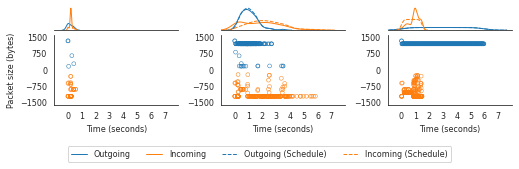

In [26]:
fig, axes = plt.subplots(2, 3, figsize=(7.25, 2), sharex=True, gridspec_kw=dict(height_ratios=[1,3]))

C1 = ["#1f77b4", "#ff7f0e"]
C2 = ["#2ca02c", "#d62728"]

def plot_packets(trace, axes, *, min_pkt_size):
    trace = trace[np.abs(trace["size"]) >= min_pkt_size]
    
    outgoing = trace[trace["size"] > 0]
    incoming = trace[trace["size"] < 0]
    axes.scatter(outgoing["time"], outgoing["size"], marker='o', s=15, facecolor="none", edgecolor=C1[0], linewidth=.5)
    axes.scatter(incoming["time"], incoming["size"], marker='o', s=15, facecolor="none", edgecolor=C1[1], linewidth=.5)
    axes.set_yticks([-1500, -750, 0, 750, 1500])
    axes.set_ylim(-1600, 1600)
    axes.set_xticks([0, 1, 2, 3, 4, 5, 6, 7])
    axes.set_xlim(-1, 8)
    
def plot_hist(trace, axes, *, min_pkt_size, c, **kws):
    trace = trace[np.abs(trace["size"]) >= min_pkt_size]
    
    outgoing = trace[trace["size"] > 0]
    incoming = trace[trace["size"] < 0]
    sns.kdeplot(outgoing["time"], ax=axes, color=c[0], linewidth=1, **kws)
    sns.kdeplot(incoming["time"], ax=axes, color=c[1], linewidth=1, **kws)

plot_packets(control, axes[1, 0], min_pkt_size=150)
plot_hist(control, axes[0, 0], min_pkt_size=150, c=C1)

plot_packets(front, axes[1, 1], min_pkt_size=150)
plot_hist(front, axes[0, 1], min_pkt_size=150, c=C1)
plot_hist(frontsched, axes[0, 1], min_pkt_size=150, c=C1, linestyle="--")

plot_packets(tamaraw, axes[1, 2], min_pkt_size=250)
plot_hist(tamaraw, axes[0, 2], min_pkt_size=250, c=C1)
plot_hist(tamarawsched, axes[0, 2], min_pkt_size=250, c=C1, linestyle="--")

for ax in axes[:, 1:].ravel():
    ax.set_ylabel(None)
    
for ax in axes[1, :].ravel():
    ax.set_xlabel("Time (seconds)")
    
for ax in axes[0, :].ravel():
    # fig.axes.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.grid(False)
    # ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
for ax in axes[1, :].ravel():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # ax.hlines(0, -1, 8, color="gray", linewidth=.75)
    # ax.spines['bottom'].set_visible(False)
    # ax.spines['left'].set_visible(False)
    
axes[1, 0].set_ylabel("Packet size (bytes)")
    
# handles, labels = axes[1, 2].get_legend_handles_labels()
fig.legend(axes[0, 2].get_lines(), ["Outgoing", "Incoming", "Outgoing (Schedule)", "Incoming (Schedule)"], loc='upper center', bbox_to_anchor=(.5, 0), ncol=4)

fig.tight_layout(h_pad=0.5)
fig.savefig(OUTPUT_FILE.with_suffix(".png"), bbox_inches="tight", dpi=150)
fig.savefig(OUTPUT_FILE.with_suffix(".pgf"), backend="pgf", bbox_inches="tight")